# Notebooks as experiments

The `.ipynb` format is capable of storing tables and charts in a standalone file. This makes it a great choice for model evaluation reports. `NotebookCollection` allows you to retrieve results from previously executed notebooks to compare them.

In [1]:
import urllib.request

from ploomber_engine import execute_notebook
import jupytext

from sklearn_evaluation import NotebookCollection

Let's first generate a few notebooks, we have a `train.py` script that trains a single model, let's convert it to a jupyter notebook:

In [2]:
# download script
url = "https://raw.githubusercontent.com/ploomber/sklearn-evaluation/master/docs-assets/nb-collection/train.py"  # noqa
urllib.request.urlretrieve(url, filename="train.py")

# convert
nb = jupytext.read("train.py")
jupytext.write(nb, "train.ipynb")

We use papermill to execute the notebook with different parameters, we'll train 4 models: 2 random forest, a linear regression and a support vector regression:

In [3]:
# models with their corresponding parameters
params = [
    {"model": "sklearn.ensemble.RandomForestRegressor", "params": {"n_estimators": 50}},
    {
        "model": "sklearn.ensemble.RandomForestRegressor",
        "params": {"n_estimators": 100},
    },
    {"model": "sklearn.linear_model.LinearRegression", "params": {}},
    {"model": "sklearn.svm.LinearSVR", "params": {}},
]

# ids to identify each experiment
ids = [
    "random_forest_1",
    "random_forest_2",
    "linear_regression",
    "support_vector_regression",
]

# output files
files = [f"{i}.ipynb" for i in ids]

# execute notebooks using papermill
for f, p in zip(files, params):
    execute_notebook("train.ipynb", output_path=f, parameters=p, progress_bar=False)

To use `NotebookCollection`, we pass a a list of paths, and optionally, ids for each notebook (uses paths by default).

The only requirement is that cells whose output we want to extract must have tags, each tag then becomes a key in the notebook collection. For instructions on adding tags, [see this](https://papermill.readthedocs.io/en/latest/usage-parameterize.html).

Extracted tables add colors to certain cells to identify the best and worst metrics. By default, it assumes that metrics are errors (smaller is better). If you are using scores (larger is better), pass `scores=True`, if you have both, pass a list of scores:

In [4]:
nbs = NotebookCollection(paths=files, ids=ids, scores=["r2"])

To get a list of tags available:

In [5]:
list(nbs)

['model_name', 'feature_names', 'model_params', 'plot', 'metrics', 'houseage']

`model_params` contains a dictionary with model parameters, let's get them (click on the tabs to switch):

In [6]:
# pro-tip: then typing the tag, press the "Tab" key for autocompletion!
nbs["model_params"]

`plot` has a `y_true` vs `y_pred` chart:

In [7]:
nbs["plot"]

On each notebook, `metrics` outputs a data frame with a single row with mean absolute error (mae) and mean squared error (mse) as columns.

For single-row tables, a "Compare" tab shows all results at once:

In [8]:
nbs["metrics"]

We can see that the second random forest is performing the best in both metrics.

`houseage` contains a multi-row table where with error metrics broken down by the `HouseAge` indicator feature. Multi-row tables *do not* display the "Compare" tab:

In [9]:
nbs["houseage"]

If we only compare two notebooks, the output is a bit different:

In [10]:
# only compare two notebooks
nbs_two = NotebookCollection(paths=files[:2], ids=ids[:2], scores=["r2"])

Comparing single-row tables includes a diff column with the error difference between experiments. Error reductions are showed in green, increments in red:

In [11]:
nbs_two["metrics"]

When comparing multi-row tables, the "Compare" tab appears, showing the difference between the tables:

In [12]:
nbs_two["houseage"]

When displaying dictionaries, a "Compare" tab shows with a diff view:

In [13]:
nbs_two["model_params"]

Lists (and sets) are compared based on elements existence:

In [14]:
nbs_two["feature_names"]

## Using the mapping interface

`NotebookCollection` has a dict-like interface, you can retrieve data from individual notebooks:

In [15]:
nbs["model_params"]["random_forest_1"]

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

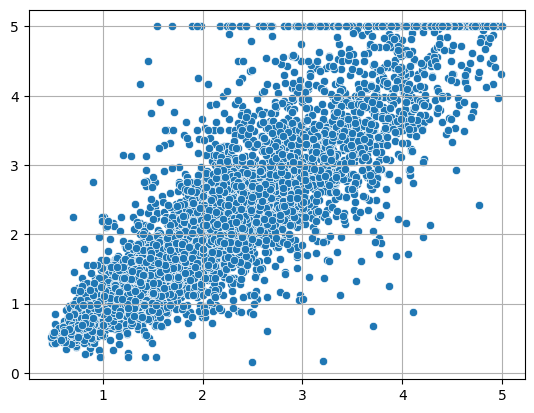

In [16]:
nbs["plot"]["random_forest_2"]